In [69]:
import platform
import matplotlib.pyplot as plt

# 한글 깨짐 방지
if platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

In [70]:
import pandas as pd
tt_df=pd.read_csv('trump_senti_point.csv')
ht_df=pd.read_csv('harris_senti_point.csv')

In [71]:
tt_df.tail()

,neg,neu,pos,compound,sentiment
56,0.063000,0.650000,0.287000,0.892000,1.000000
57,0.078375,0.789750,0.131875,0.053625,0.250000
58,0.000000,0.895351,0.104649,0.131176,0.500000
59,0.109565,0.791826,0.098609,-0.246913,-0.195652
60,0.037000,0.849143,0.113857,0.188000,0.285714


In [72]:
tt_lstm_list=tt_df['sentiment'].values.tolist()
ht_lstm_list=ht_df['sentiment'].values.tolist()

In [73]:
import numpy as np

window_size=7
X_tt=[]
X_th=[]
Y_tt=[]
Y_th=[]

for i in range(len(ht_lstm_list)-window_size):
    X_tt.append([tt_lstm_list[i+j] for j in range(window_size)])
    X_th.append([ht_lstm_list[i+j] for j in range(window_size)])
    Y_tt.append(tt_lstm_list[window_size+i])
    Y_th.append(ht_lstm_list[window_size+i])

X_tt= np.array(X_tt)
Y_tt= np.array(Y_tt)
X_th= np.array(X_th)
Y_th= np.array(Y_th)

In [74]:
X_th.shape

(54, 7)

In [75]:
# 7개 테스트
train_test_split = 45

X_tt_train = X_tt[:train_test_split,:]
Y_tt_train = Y_tt[:train_test_split]

X_th_train = X_th[:train_test_split,:]
Y_th_train = Y_th[:train_test_split]

X_tt_test = X_tt[train_test_split:,:]
Y_tt_test = Y_tt[train_test_split:]

X_th_test = X_th[train_test_split:,:]
Y_th_test = Y_th[train_test_split:]

X_tt_train=np.reshape(X_tt_train, (X_tt_train.shape[0], window_size, 1))
X_th_train=np.reshape(X_th_train, (X_th_train.shape[0], window_size, 1))
X_tt_test=np.reshape(X_tt_test, (X_tt_test.shape[0], window_size, 1))
X_th_test=np.reshape(X_th_test, (X_th_test.shape[0], window_size, 1))

In [76]:
!pip install keras

In [77]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *

tt_model = Sequential()
tt_model.add(LSTM(128, input_shape=(7,1,)))
tt_model.add(Dropout(0.2))
tt_model.add(Dense(1, activation='linear'))     #output은 1개
tt_model.compile(loss='mse', optimizer='adam')
tt_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,689 (260.50 KB)

 Trainable params: 66,689 (260.50 KB)

 Non-trainable params: 0 (0.00 B)

In [78]:
th_model = Sequential()
th_model.add(LSTM(128, input_shape=(7,1,)))
th_model.add(Dropout(0.2))
th_model.add(Dense(1, activation='linear'))        #output은 1개
th_model.compile(loss='mse', optimizer='adam')
th_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                        │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,689 (260.50 KB)

 Trainable params: 66,689 (260.50 KB)

 Non-trainable params: 0 (0.00 B)

In [79]:
tt_model.fit(X_tt_train, Y_tt_train, epochs=200, batch_size=1, verbose=1)

Epoch 1/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1084
Epoch 2/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0968
Epoch 3/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0639
Epoch 4/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0752
Epoch 5/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0933
Epoch 6/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0727
Epoch 7/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1014
Epoch 8/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0715
Epoch 9/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1008
Epoch 10/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0706
Epoch 11/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0603
Epoch 12/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0996
Epoch 13/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0799
Epoch 14/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0730
Epoch 15/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0923
Epoc

In [80]:
th_model.fit(X_th_train, Y_th_train, epochs=200, batch_size=1, verbose=1)

Epoch 1/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0956
Epoch 2/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1046
Epoch 3/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1514
Epoch 4/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1356
Epoch 5/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1214
Epoch 6/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1013
Epoch 7/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0917
Epoch 8/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0840
Epoch 9/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1257
Epoch 10/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1495
Epoch 11/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0904
Epoch 12/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0936
Epoch 13/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1030
Epoch 14/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1501
Epoch 15/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1477
Epoc

In [88]:
tt_train_predict=tt_model.predict(X_tt_train)
tt_test_predict=tt_model.predict(X_tt_test)
th_train_predict=th_model.predict(X_th_train)
th_test_predict=th_model.predict(X_th_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


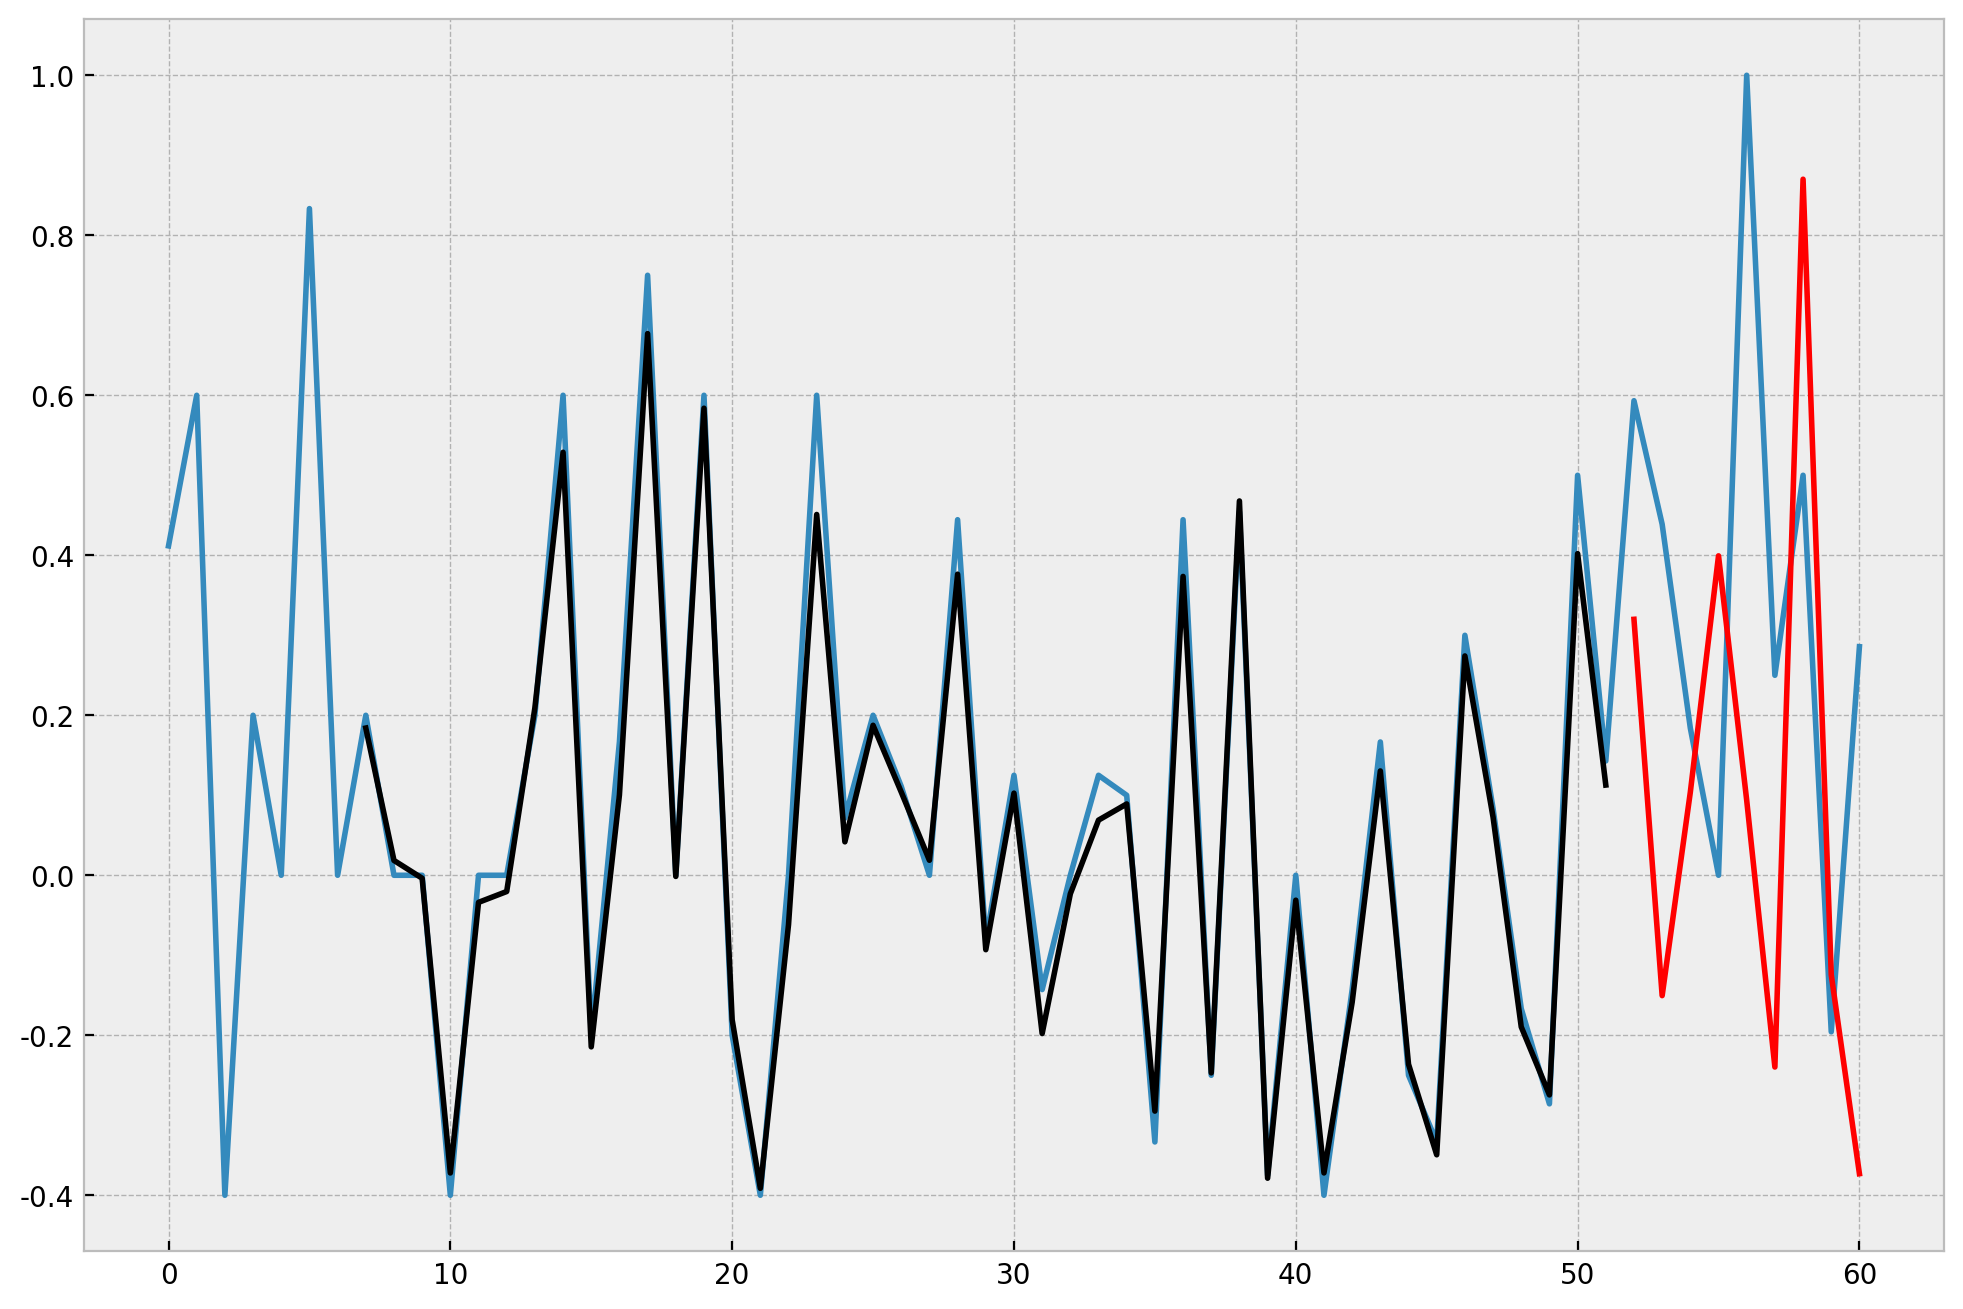

In [89]:
import matplotlib.pyplot as plt
plt.style.use('bmh')

plt.figure(figsize=(12,8))
plt.plot(tt_lstm_list)

split_pt = train_test_split + window_size
plt.plot(np.arange(window_size, split_pt, 1), tt_train_predict, color='black')
plt.plot(np.arange(split_pt,split_pt+len(tt_test_predict), 1), tt_test_predict, color='red')

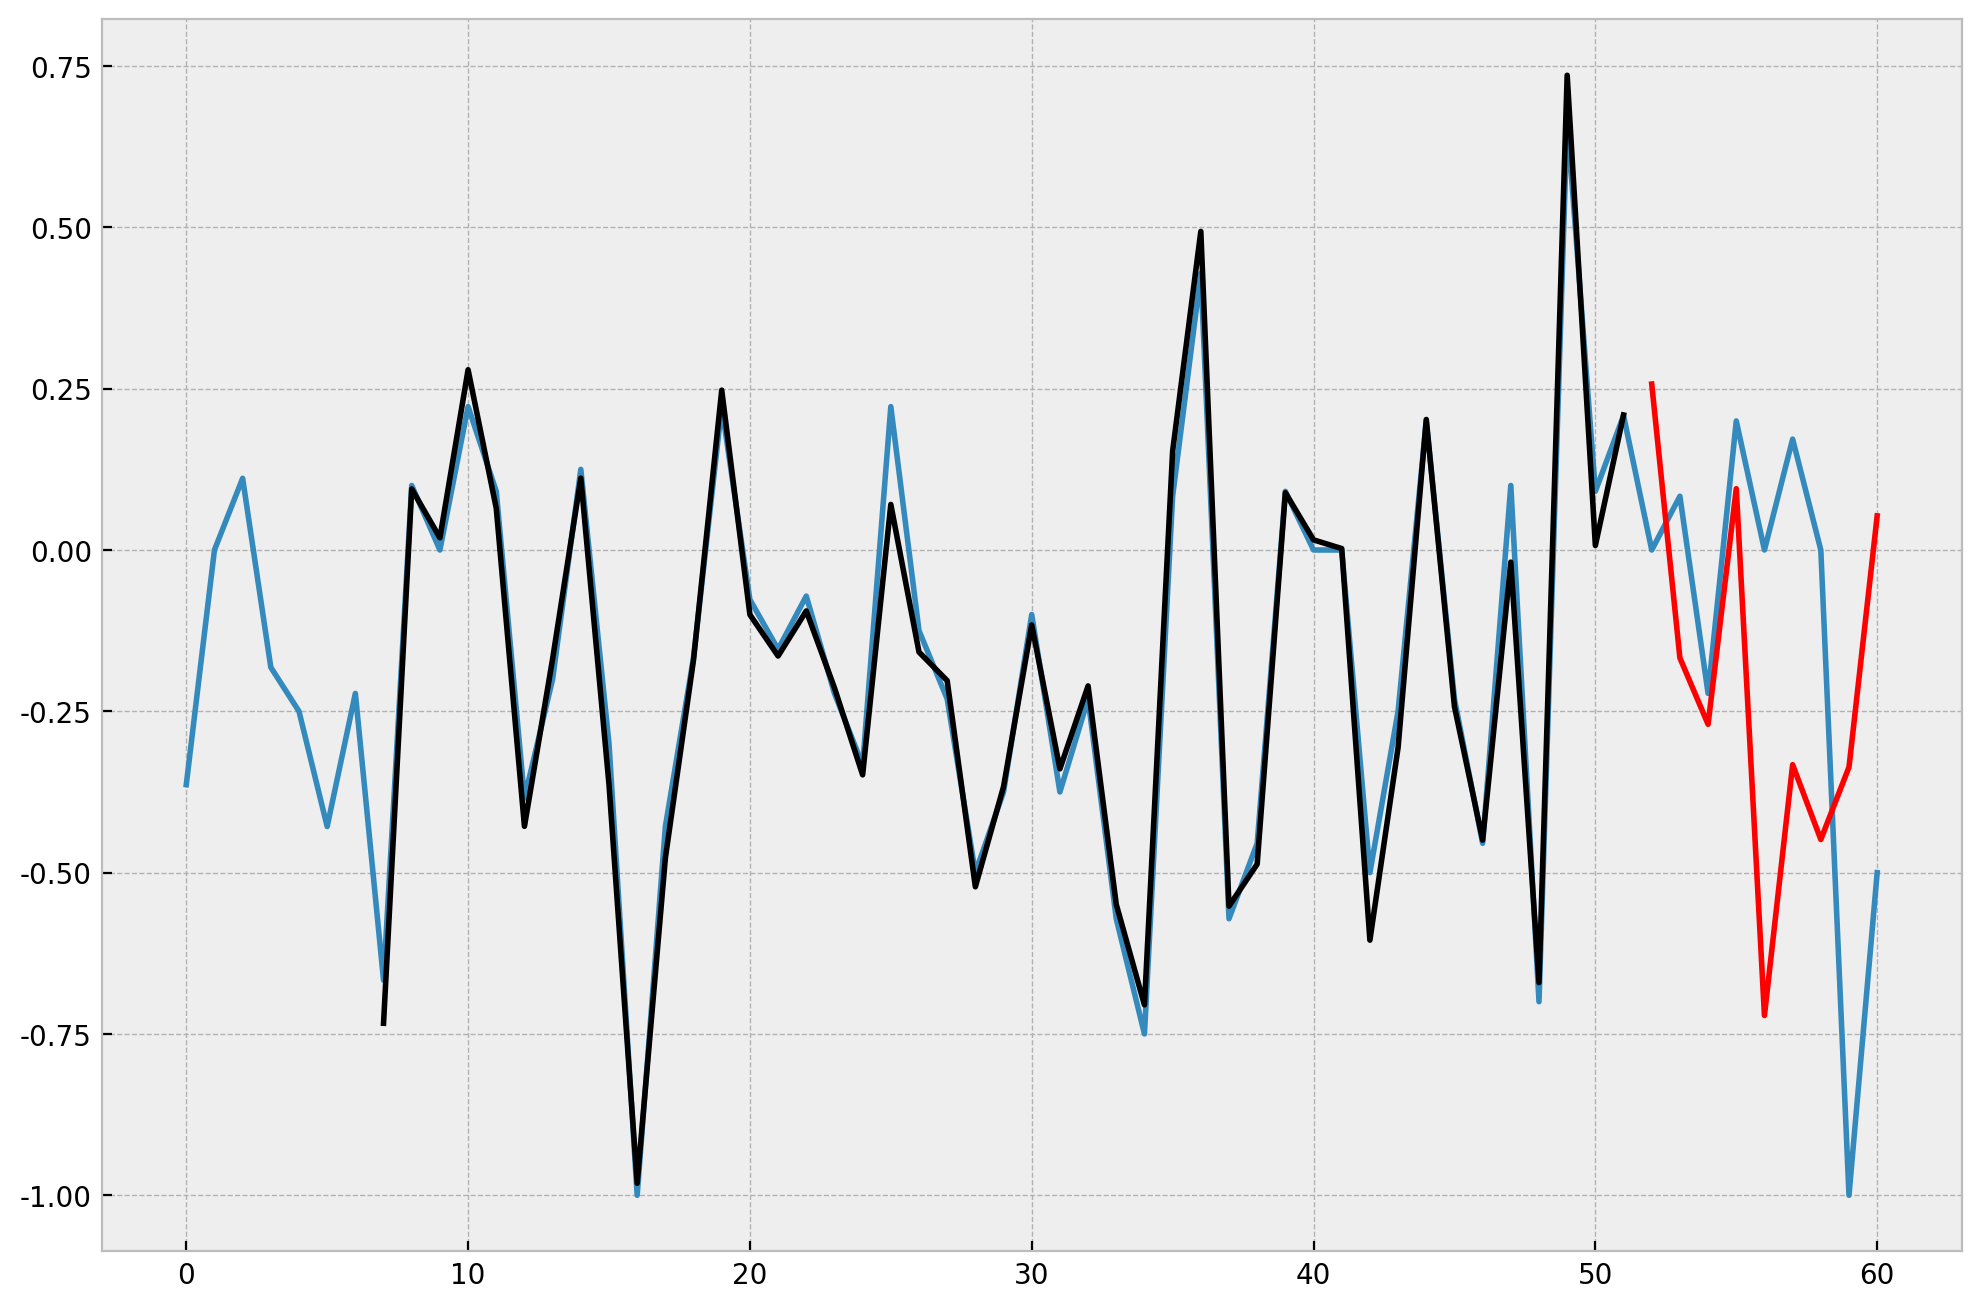

In [90]:
plt.figure(figsize=(12,8))
plt.plot(ht_lstm_list)

split_pt = train_test_split + window_size
plt.plot(np.arange(window_size, split_pt, 1), th_train_predict, color='black')
plt.plot(np.arange(split_pt, split_pt+len(th_test_predict), 1), th_test_predict, color='red')

In [91]:
tt_model.save("tt_model.h5")
th_model.save("th_model.h5")

In [92]:
#트럼프
nFuture = 5
if len(tt_lstm_list) > 100:

    t_lastData = np.copy(tt_lstm_list[-100:])  # 원 데이터의 마지막 100개만 그려본다

else:

    t_lastData = np.copy(tt_lstm_list)

t_dx = np.copy(t_lastData)

#해리스
if len(ht_lstm_list) > 100:

    h_lastData = np.copy(ht_lstm_list[-100:])  # 원 데이터의 마지막 100개만 그려본다

else:

    h_lastData = np.copy(ht_lstm_list)

h_dx = np.copy(h_lastData)

In [93]:
# trump
nStep=7

t_estimate = [t_dx[-1]]

for i in range(nFuture):

    # 마지막 nStep 만큼 입력데이로 다음 값을 예측한다

    t_px = t_dx[-nStep:].reshape(1, nStep, 1)
    # 다음 값을 예측한다.
    t_yHat = tt_model.predict(t_px)[0][0]

    # 예측값을 저장해 둔다
    t_estimate.append(t_yHat)

    # 이전 예측값을 포함하여 또 다음 값을 예측하기위해 예측한 값을 저장해 둔다
    t_dx = np.insert(t_dx, len(t_dx), t_yHat)

# harris
h_estimate = [h_dx[-1]]

for i in range(nFuture):

    # 마지막 nStep 만큼 입력데이로 다음 값을 예측한다

    h_px = h_dx[-nStep:].reshape(1, nStep, 1)
    # 다음 값을 예측한다.
    h_yHat = th_model.predict(h_px)[0][0]

    # 예측값을 저장해 둔다
    h_estimate.append(h_yHat)

    # 이전 예측값을 포함하여 또 다음 값을 예측하기위해 예측한 값을 저장해 둔다
    h_dx = np.insert(h_dx, len(h_dx), h_yHat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


<ipython-input-94-8bd22a760db6>:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-o" (-> color='b'). The keyword argument will take precedence.
  plt.plot(t_ax1, t_lastData, 'b-o', color='blue', markersize=3, label='Original sentiment score', linewidth=1)
<ipython-input-94-8bd22a760db6>:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-o" (-> color='b'). The keyword argument will take precedence.
  plt.plot(t_ax2, t_estimate, 'b-o', color='red', markersize=3, label='Estimate score')


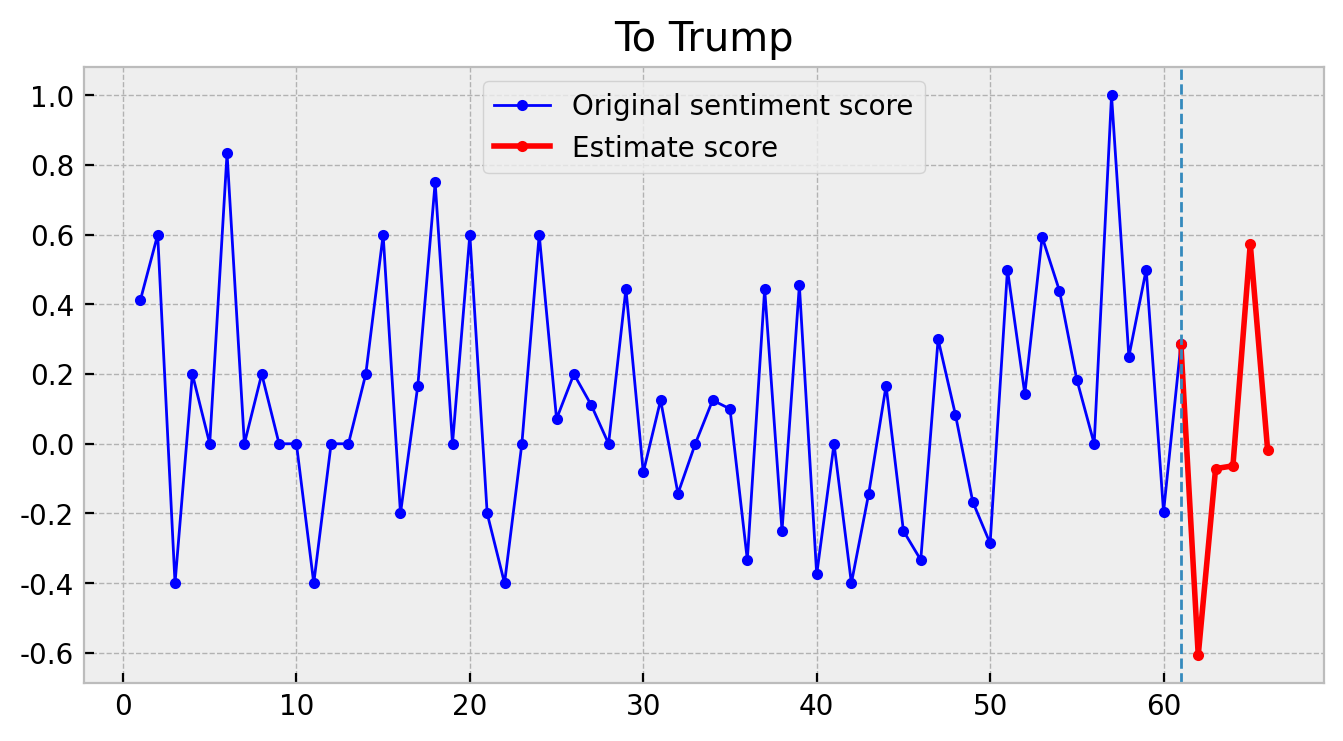

<ipython-input-94-8bd22a760db6>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-o" (-> color='b'). The keyword argument will take precedence.
  plt.plot(h_ax1, h_lastData, 'b-o', color='blue', markersize=3, label='Original sentiment score', linewidth=1)
<ipython-input-94-8bd22a760db6>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-o" (-> color='b'). The keyword argument will take precedence.
  plt.plot(h_ax2, h_estimate, 'b-o', color='red', markersize=3, label='Estimate score')


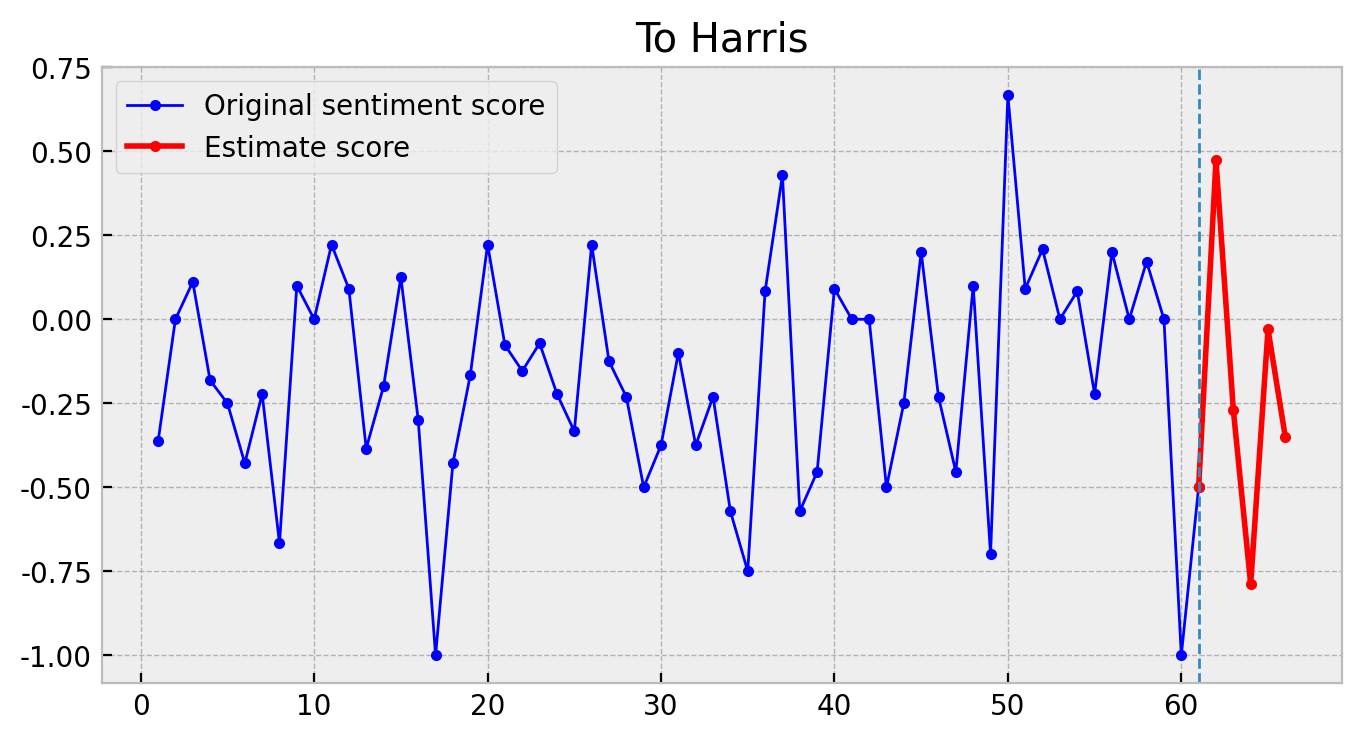

In [94]:
#Trump
t_ax1 = np.arange(1, len(t_lastData) + 1)

t_ax2 = np.arange(len(t_lastData), len(t_lastData) + len(t_estimate))

plt.figure(figsize=(8, 4))

plt.title("To Trump")

plt.plot(t_ax1, t_lastData, 'b-o', color='blue', markersize=3, label='Original sentiment score', linewidth=1)

plt.plot(t_ax2, t_estimate, 'b-o', color='red', markersize=3, label='Estimate score')

plt.axvline(x=t_ax1[-1],  linestyle='dashed', linewidth=1)

plt.legend()

plt.show()

# Harris
h_ax1 = np.arange(1, len(h_lastData) + 1)

h_ax2 = np.arange(len(h_lastData), len(h_lastData) + len(h_estimate))

plt.figure(figsize=(8, 4))

plt.title("To Harris")

plt.plot(h_ax1, h_lastData, 'b-o', color='blue', markersize=3, label='Original sentiment score', linewidth=1)

plt.plot(h_ax2, h_estimate, 'b-o', color='red', markersize=3, label='Estimate score')

plt.axvline(x=h_ax1[-1],  linestyle='dashed', linewidth=1)

plt.legend()

plt.show()